# Business Analysis

You've done beautifully in the Practicum course, and you've been offered an internship in the analytical department at Yandex.Afisha. Your first task is to help optimize marketing expenses.  
  
You have:
- Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics  
  
You are going to study:
- How people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

**The main goal is to study customers behavior and find the most effective sources**

### Table of Contents <a class="anchor" id="contents"></a>

* [1.Preparing data for analysis](#chapter1)
    * [VISITS](#section_1_1)
    * [ORDERS](#section_1_2)
    * [COSTS](#section_1_3)
* [2. Metrics and calculations](#chapter2)
    * [PRODUCT](#section_2_1)
        * [Number of users](#section_2_1_1)
        * [Number of sessions](#section_2_1_2)
        * [ASL](#section_2_1_3)
        * [Retention rate](#section_2_1_4)
    * [SALES](#section_2_2)
        * [Conversion](#section_2_2_1)
        * [Orders](#section_2_2_2)
        * [Average purchase size](#section_2_2_3)
        * [LTV](#section_2_2_4)    
    * [MARKETING](#section_3_2)
        * [Costs](#section_3_2_1)
        * [CAC](#section_3_2_2)
        * [ROI](#section_3_2_3)
* [3. Conclusions](#chapter3)        

### 1. Preparing data for analysis <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Firstly I am going to check the files for the size and types of data on the sample of 100 rows and then convert the parametres in necessary types and upload the full base for further analysis.

#### VISITS <a class="anchor" id="section_1_1"></a>

In [2]:
visits = pd.read_csv('visits_log_us.csv',
                    dtype={'Device': 'category'},
                    parse_dates=['Start Ts', 'End Ts'])
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [3]:
print('Duplicates:', visits.duplicated().sum())

Duplicates: 0


In [4]:
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


The table now seems fine - there are no strange values, no duplicates and no missing values. I have changed dates into datetime format and turned 'Device' into categorical variable as soon as there are two nomila values: 'touch' and 'desktop'.

#### ORDERS <a class="anchor" id="section_1_2"></a>

In [5]:
orders = pd.read_csv('orders_log_us.csv',
                    parse_dates=['Buy Ts'])
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [6]:
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [7]:
print('Duplicates:', orders.duplicated().sum())

Duplicates: 0


In [8]:
print('Zero-revenue orders:', len(orders[orders['Revenue'] == 0]))

Zero-revenue orders: 51


In [9]:
orders = orders.drop(orders[orders.Revenue == 0].index)
print('Zero-revenue orders:', len(orders[orders['Revenue'] == 0]))

Zero-revenue orders: 0


There are no missing values, but there are zero-revenue orders which seems strange. 51 rows its less than 0.5% so I dropped them from the future analysis. I converted dates into dates, other columns are fine from the point of data type.

#### COSTS <a class="anchor" id="section_1_3"></a>

In [10]:
costs = pd.read_csv('costs_us.csv',
                    parse_dates=['dt'])
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [11]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


In [12]:
print('Duplicates:', costs.duplicated().sum())

Duplicates: 0


In the 'costs' table there were zero values for costs, all dates are here (and changed them into date types), no duplicates. Seems good to go.

[back to contents](#contents)

### 2. Metrics and calculations <a class="anchor" id="chapter2"></a>

#### PRODUCT <a class="anchor" id="section_2_1"></a>

##### Number of users <a class="anchor" id="section_2_1_1"></a> 
How many people use it every day, week, and month?

In [13]:
#Firstly I will extract neccessary 'date'parts from the date column:
visits['start_ts_year']  = visits['Start Ts'].dt.year
visits['start_ts_month'] = visits['Start Ts'].dt.month
visits['start_ts_week']  = visits['Start Ts'].dt.week
visits['start_ts_date'] = visits['Start Ts'].dt.date

In [14]:
dau_total = visits.groupby(['start_ts_date']).agg({'Uid': 'nunique'}).reset_index()
dau_total.columns = ['date', 'dau']
print('Average daily users:', round(dau_total['dau'].mean()))

Average daily users: 908


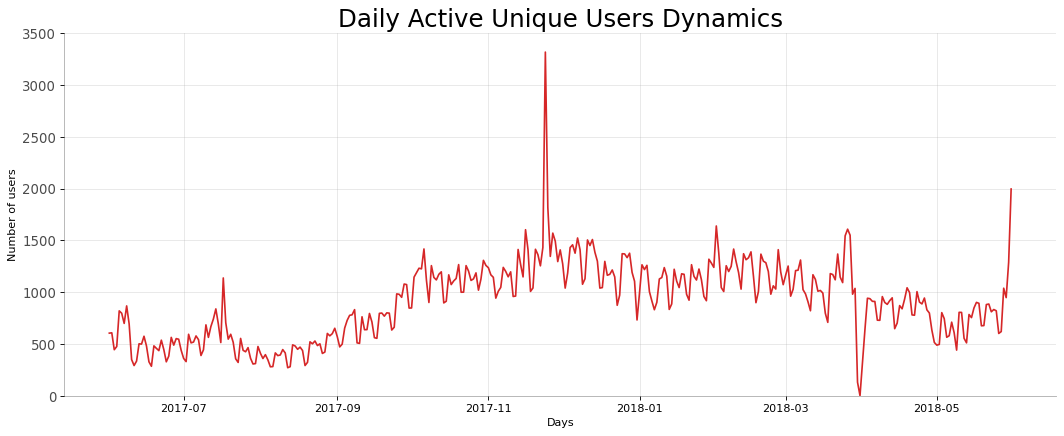

In [15]:
# Draw Plot
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('date', 'dau', data=dau_total, color='tab:red')

# Decoration
plt.ylim(0, 3500)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Daily Active Unique Users Dynamics", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.xlabel('Days')
plt.ylabel('Number of users')
# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

What we see here? The average number of daily users is **908**.  
In **December** there was a significant increase in daily users number. Maybe it was related to some marketing campaign or Christmas influenced (people tend to spend tume outside, go to the movies (use Afisha)).  
Alternatively in **April** there was some kind of break-down - or the system was working but not collecting data (need report to data collection team) or the whole serivce wasnt available for the users at all.  
And finally in the end of **May** another growth happened, but we dont see whether it countinued or not. Seems to be seasonal as soon as summer starts and people look for the ways to spend their free time.

In [16]:
visits['day_of_week'] = visits['Start Ts'].dt.weekday

In [17]:
visits['first_day_of_the_week'] = visits['Start Ts'] - visits['day_of_week'] * timedelta(days=1)
visits['first_day_of_the_week'] = visits['first_day_of_the_week'].dt.date

In [18]:
wau_total = visits.groupby(['first_day_of_the_week']).agg({'Uid': 'nunique'}).reset_index()
wau_total.columns = ['week', 'wau']
wau_total.head()

,week,wau
0,2017-05-29,2021
1,2017-06-05,4129
2,2017-06-12,2812
3,2017-06-19,2878
4,2017-06-26,3064


In [19]:
print('Average weekly users:', round(wau_total['wau'].mean()))

Average weekly users: 5716


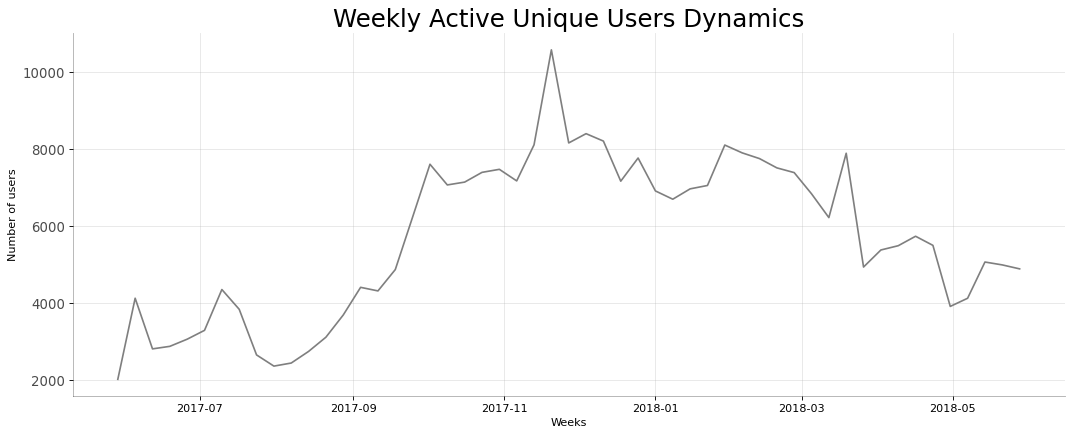

In [20]:
# Draw Plot
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('week', 'wau', data=wau_total, color='tab:grey')

# Decoration
plt.yticks(fontsize=12, alpha=.7)
plt.title("Weekly Active Unique Users Dynamics", fontsize=22)
plt.grid(axis='both', alpha=.3)

plt.xlabel('Weeks')
plt.ylabel('Number of users')
# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

The average number of weekly active users is **5716**.  
By the dynamics we see that there was general rise of number of users at the end of 2017th and the beginning of 2018.

In [21]:
visits['month_year'] = pd.to_datetime(visits['Start Ts']).dt.to_period('M')

In [22]:
mau_total = visits.groupby(['month_year']).agg({'Uid': 'nunique'})
mau_total.columns = ['mau']
print('Average montly users:', round(mau_total['mau'].mean()))

Average montly users: 23228


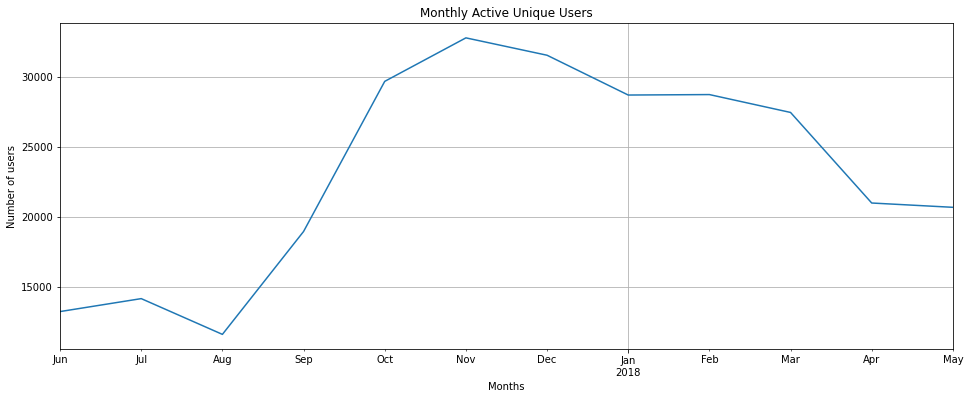

In [23]:
mau_total.plot(y='mau',
               kind='line',
               figsize=(16,6), 
               title = 'Monthly Active Unique Users',
               grid = True,
               legend = False)
plt.xlabel('Months')
plt.ylabel('Number of users')
plt.show()

The average number of monthly users is **23228**.  
On this graph we see the some confirmation of assumptions made with daily users dynamics - The winter is 'high-season' for Afisha users, summer was 'low-season' in 2017, but maybe the year 2018 will be other (as we have seen an increase at the end of the May)

[back to contents](#contents)

##### Number of sessions <a class="anchor" id="section_2_1_2"></a>
How many sessions are there per day?

In [24]:
sessions_per_day = visits.groupby(['start_ts_date']).agg({'Uid': 'count'}).reset_index()
sessions_per_day.columns = ['date', 'n_sessions']
sessions_per_day.head()
print('Average sessions per day:', round(sessions_per_day['n_sessions'].mean()))

Average sessions per day: 987


In [25]:
daily_sessions = visits.pivot_table(index='start_ts_date', columns='Device', values='Uid', aggfunc='count')
daily_sessions.columns = ['desktop', 'touch']

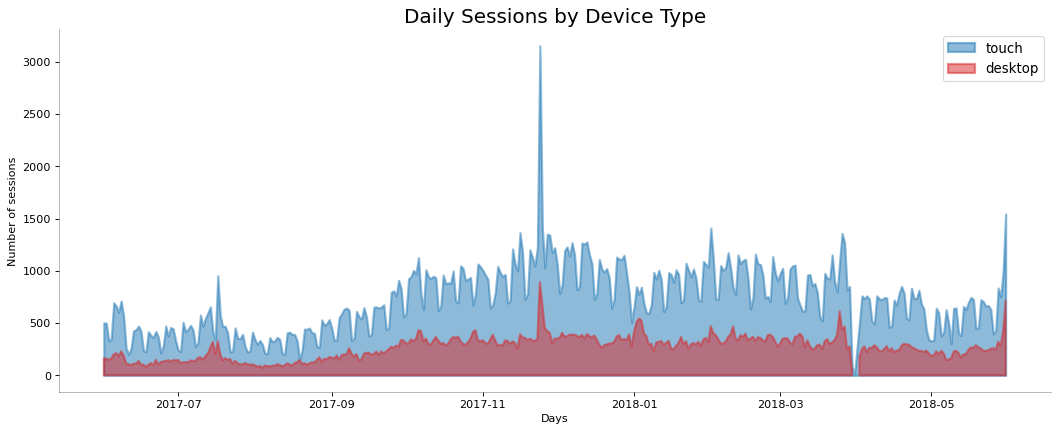

In [26]:
# Prepare Data
x = daily_sessions.index.values.tolist()
y1 = daily_sessions['desktop'].values.tolist()
y2 = daily_sessions['touch'].values.tolist()
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['desktop', 'touch']

# Draw Plot 
fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], linewidth=2)

# Decorations
ax.set_title('Daily Sessions by Device Type', fontsize=18)
ax.legend(loc='best', fontsize=12)
plt.xlabel('Days')
plt.ylabel('Number of sessions')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

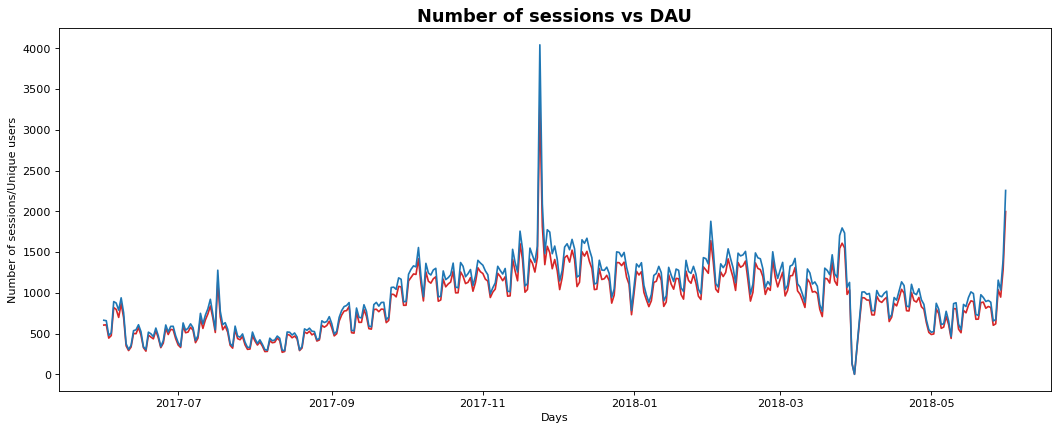

In [27]:
sessions_dau = sessions_per_day.merge(dau_total, on='date')
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('date', 'dau', data=sessions_dau, color='tab:red')
plt.plot('date', 'n_sessions', data=sessions_dau, color='tab:blue')
plt.title("Number of sessions vs DAU", fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=12)
plt.xlabel('Days')
plt.ylabel('Number of sessions/Unique users')

plt.show()

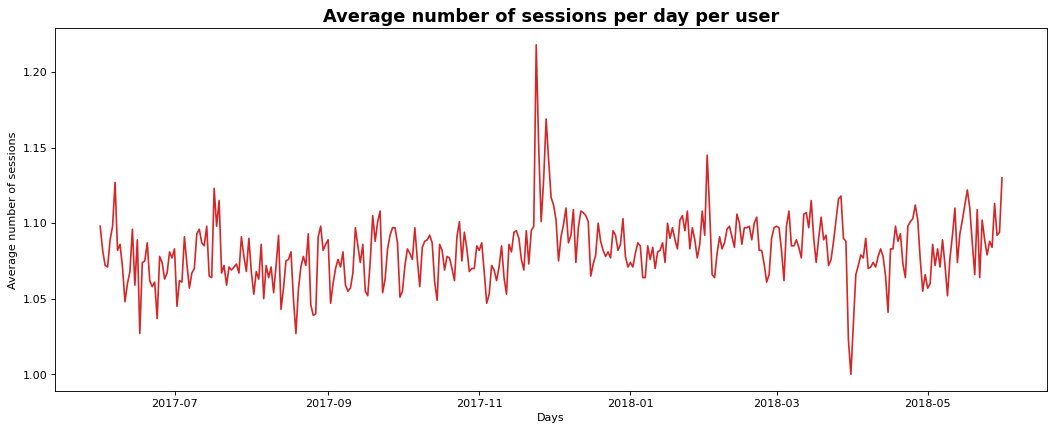

In [28]:
sessions_dau['average_n_sessions'] = (sessions_dau['n_sessions']/sessions_dau['dau']).round(3)
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('date', 'average_n_sessions', data=sessions_dau, color='tab:red')
plt.title("Average number of sessions per day per user", fontsize=16, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Average number of sessions')
plt.show()

In [29]:
print('Average sessions per day per user:', round(sessions_dau['average_n_sessions'].mean(), 1))

Average sessions per day per user: 1.1


Almost **990** sessions per day on average. The dynamics are quite similar to the daily users graph.  So to investigate further I have checked the distribution of number of sessions by device type - and we see that increase in December was made by mobile users. Hard to decide whether it is the system collection error or seasonal increase dut to holidays.  
Also I have checked the average number of sessions per user - it also shows the anomalities in December and April.  

On average there is **1.1** session per one unique user. The result is also reflected on the graph with Number of sessions and DAU - the dynamics profile is very common.

[back to contents](#contents)

##### ASL <a class="anchor" id="section_2_1_3"></a>
What is the length of each session?

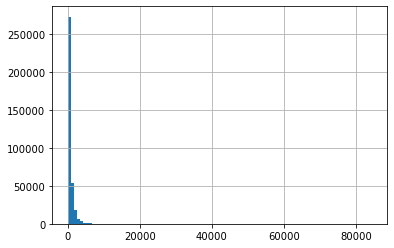

In [30]:
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds
visits['session_duration_sec'].hist(bins=100)
plt.show()

In [31]:
print('The most frequent duration of one session:')
visits['session_duration_sec'].mode()

The most frequent duration of one session:


0    60
dtype: int64

In [32]:
print('Median duration of one session:', visits['session_duration_sec'].median())

Median duration of one session: 300.0


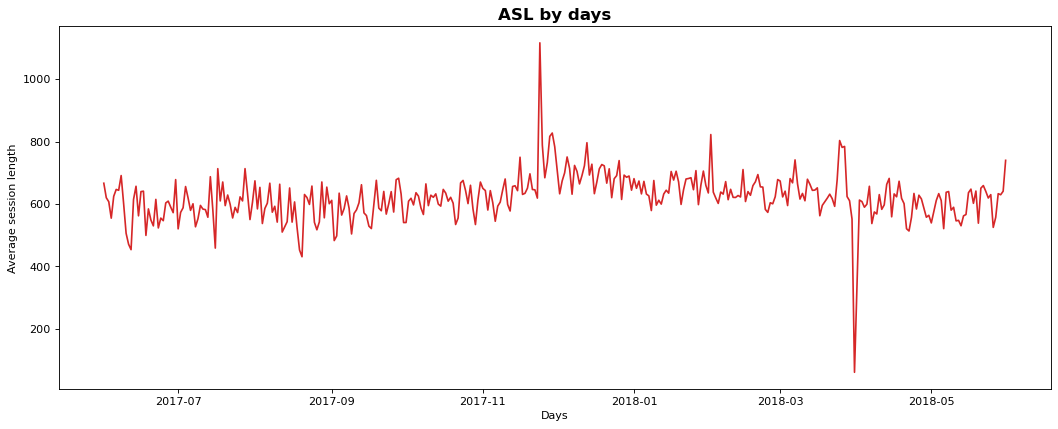

In [33]:
asl_per_day = visits.groupby(['start_ts_date']).agg({'session_duration_sec':'mean'}).reset_index()
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('start_ts_date', 'session_duration_sec', data=asl_per_day, color='tab:red')
plt.title("ASL by days", fontsize=15, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Average session length')
plt.show()

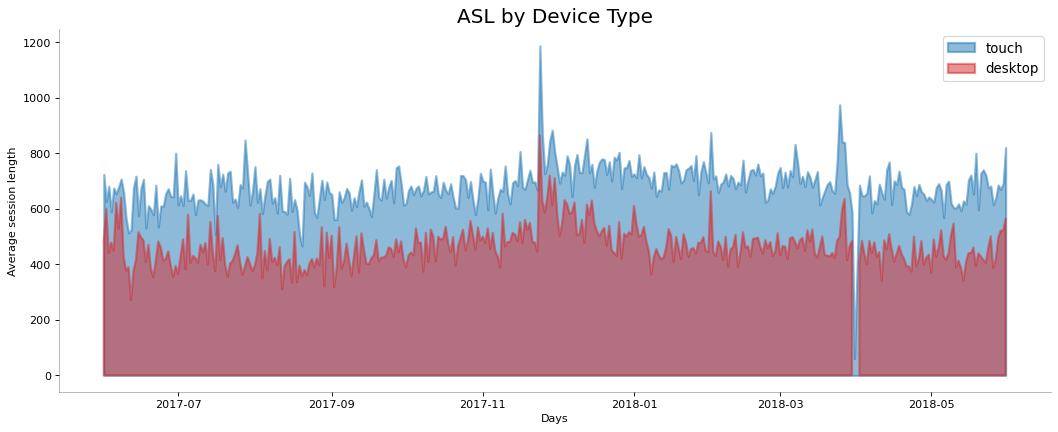

In [34]:
asl_by_device = visits.pivot_table(index='start_ts_date', columns='Device', values='session_duration_sec', aggfunc='mean')
asl_by_device.columns = ['desktop', 'touch']
# Prepare Data
x = asl_by_device.index.values.tolist()
y1 = asl_by_device['desktop'].values.tolist()
y2 = asl_by_device['touch'].values.tolist()
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      
columns = ['desktop', 'touch']

# Draw Plot 
fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label=columns[1], alpha=0.5, color=mycolors[1], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label=columns[0], alpha=0.5, color=mycolors[0], linewidth=2)

# Decorations
ax.set_title('ASL by Device Type', fontsize=18)
ax.legend(loc='best', fontsize=12)
plt.xlabel('Days')
plt.ylabel('Average session length')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)
plt.show()

**ASL is 60 seconds**. As soon it is not the normal distribution ASL will be here the mode value (the most frequent in distribution).  
The median ASL is **300 sec**. It means that 50% of users spend in the service 5 min and less.
Also I have compared average ASL by days. It again shows that in December was some huge demand from users which resulted in higher number of users and longer sessions.  
Users with mobile devices tend to spend more time for one session - does it mean that mobile interface is more difficult for users or does it offer more functions than desktop and users are more involved?

[back to contents](#contents)

##### Retention rate <a class="anchor" id="section_2_1_4"></a>
How often do users come back?

In order to find that out I will make up cohorts and analyze their behavior

In [35]:
first_activity_date = visits.groupby(['Uid'])['Start Ts'].min()
first_activity_date.name = 'first_activity_date'

In [36]:
visits = visits.join(first_activity_date, on='Uid')

In [37]:
visits['activity_month'] = visits['Start Ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [38]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round(0).astype(int)

In [39]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'Uid' : 'nunique'}).reset_index()

In [40]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_activity_month', 'Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid' : 'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

In [41]:
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
cohorts.head()

,first_activity_month,cohort_lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [42]:
cohorts_2017 = cohorts[(cohorts['first_activity_month'].dt.year == 2017) & (cohorts['cohort_lifetime'] !=0)].reset_index()
cohorts_2018 = cohorts[(cohorts['first_activity_month'].dt.year == 2018) & (cohorts['cohort_lifetime'] !=0)].reset_index()

In [43]:
retention_pivot_2017 = cohorts_2017.pivot_table(
                                index='first_activity_month',
                                columns='cohort_lifetime',
                                values='retention',
                                aggfunc='sum')

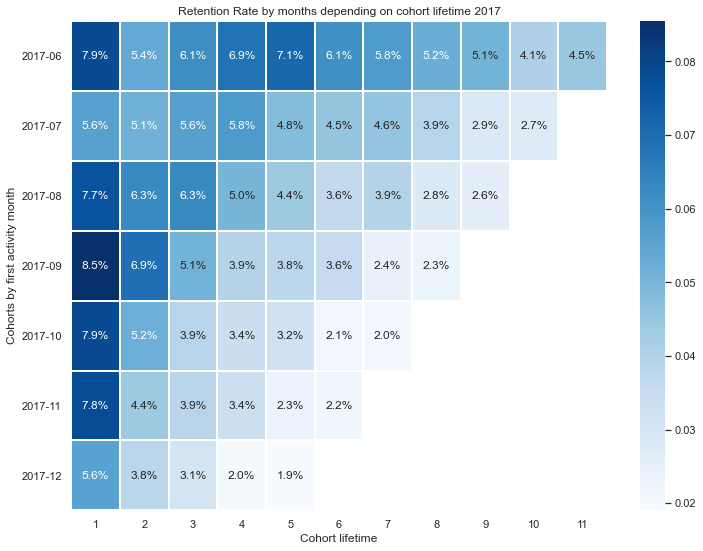

In [44]:
plt.figure(figsize=(12,9))
sns.set(style='white')
plt.title('Retention Rate by months depending on cohort lifetime 2017')

sns.heatmap(retention_pivot_2017,
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='white',
            cmap='Blues').set_yticklabels(retention_pivot_2017.index.strftime('%Y-%m'))
plt.xlabel('Cohort lifetime')
plt.ylabel('Cohorts by first activity month')
plt.show()

In [45]:
retention_pivot_2018 = cohorts_2018.pivot_table(
                                index='first_activity_month',
                                columns='cohort_lifetime',
                                values='retention',
                                aggfunc='sum')

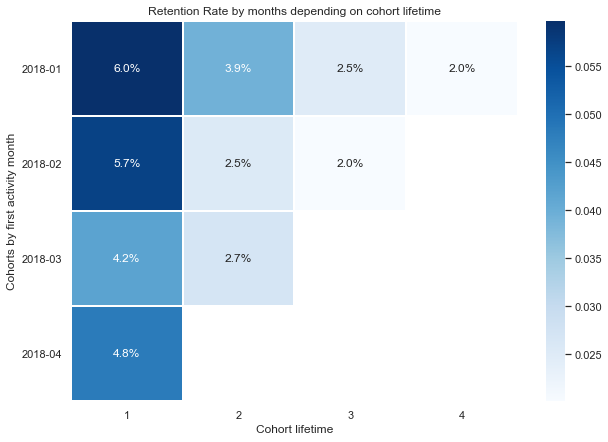

In [46]:
plt.figure(figsize=(10,7))
sns.set(style='white')
plt.title('Retention Rate by months depending on cohort lifetime')
sns.heatmap(retention_pivot_2018,
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='white',
            cmap='Blues').set_yticklabels(retention_pivot_2018.index.strftime('%Y-%m'))
plt.xlabel('Cohort lifetime')
plt.ylabel('Cohorts by first activity month')
plt.show()

I have divided users by cohorts depending on the month when they firstly very active on the website and regarded them separately for two years. I have excluded users with 0 lifetime in order more vividly demonstrate the difference in cohorts (with 100% in 0 lifetime column the heatmap does not really work - it shows no difference in colors).  
So in 2017 the **June and July cohorts** seem to be loyal and constant users of Afisha. 
**August, September, October cohorts** seemed to have good starts but then decreased their usage.  
In 2018 there was a good start after December boom, but sadly it went down pretty fast. Also as we see results of 2018 is little bit lower than ones in 2017 which could mean that regardless of big increase in number of users their retention rate is not that satisfactory.

[back to contents](#contents)

#### SALES <a class="anchor" id="section_2_2"></a>

##### Conversion <a class="anchor" id="section_2_2_1"></a>

- When do people start buying? (In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. You can use any approach that lets you compare the conversions of different cohorts, so that you can determine which cohort, or marketing channel, is most effective.)

In [47]:
orders['order_date'] = orders['Buy Ts'].dt.date
first_orders = orders.groupby(['Uid']).agg({'order_date':'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order']

In [48]:
first_visit = visits.groupby(['Uid']).agg({'start_ts_date':'min'}).reset_index()
first_visit.columns = ['Uid', 'first_visit']

In [49]:
conversion = first_orders.merge(first_visit, on='Uid')
conversion['conversion'] = (conversion['first_order'] - conversion['first_visit'])/np.timedelta64(1, 'D')
conversion[conversion['conversion'] < 0]

,Uid,first_order,first_visit,conversion


In [50]:
def conversion_group(conversion):
    if conversion == 0:
        return 'Conversion 0d'
    if  1 <= conversion <= 7:
        return 'Conversion 7d'
    if  8 <= conversion <= 14:
        return 'Conversion 14d'
    if  15 <= conversion <= 30:
        return 'Conversion 30d'
    return 'Conversion 30d+'

In [51]:
conversion['conversion_group'] = conversion['conversion'].apply(conversion_group)
conversion['conversion_group'].value_counts()

Conversion 0d      25025
Conversion 30d+     4935
Conversion 7d       4297
Conversion 30d      1277
Conversion 14d       975
Name: conversion_group, dtype: int64

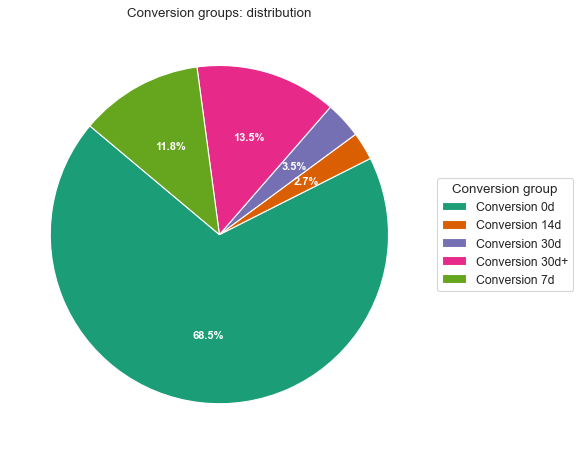

In [52]:
# Prepare Data
conversion_groups = conversion.groupby('conversion_group').size().reset_index(name='counts')
# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = conversion_groups['counts']
categories = conversion_groups['conversion_group']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                  startangle=140)

# Decoration
ax.legend(wedges, categories, title="Conversion group", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Conversion groups: distribution")
plt.show()

In [53]:
visits1 = pd.merge(visits, conversion, how='inner', on='Uid')

In [54]:
conversions_sources = pd.crosstab(visits1['Source Id'],visits1['conversion_group']).apply(lambda r: r/r.sum(), axis=1)
conversions_sources = conversions_sources[['Conversion 0d',
                                           'Conversion 7d',
                                           'Conversion 14d',
                                           'Conversion 30d',
                                           'Conversion 30d+']]
conversions_sources.drop(conversions_sources.index[5], inplace=True)

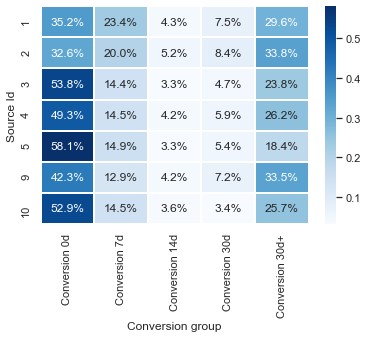

In [55]:
sns.heatmap(conversions_sources,
            annot=True,
            fmt='.1%', linewidths=1,
            linecolor='white',
            cmap='Blues')
plt.xlabel('Conversion group')
plt.ylabel('Source Id')
plt.show()

So what we see?  
About **70%** of users come back on the very first day. However, the share of 30 and more days group is also significant (~14%) and needs research why it happens.  
The most effective sources of users are **5, 3 and 10** with more than half of users doing their first order with first visit. 

[back to contents](#contents)

##### Orders <a class="anchor" id="section_2_2_2"></a>

- How many orders do they make during a given period of time?

In [56]:
daily_orders = orders.groupby(['order_date']).agg({'Uid': 'count'}).reset_index()
daily_orders.columns = ['date', 'n_users']

In [57]:
daily_orders1 = orders.groupby(['order_date']).agg({'Uid': 'nunique'}).reset_index()
daily_orders1.columns = ['date', 'n_orders']
daily_orders = daily_orders.merge(daily_orders1, on='date')

In [58]:
daily_orders['date'] = pd.to_datetime(daily_orders['date'])

In [59]:
(daily_orders[daily_orders['date'] >= '2017-12-01']['n_users'].sum() / 
 daily_orders[daily_orders['date'] >= '2017-12-01']['n_orders'].sum()).round(2)

1.08

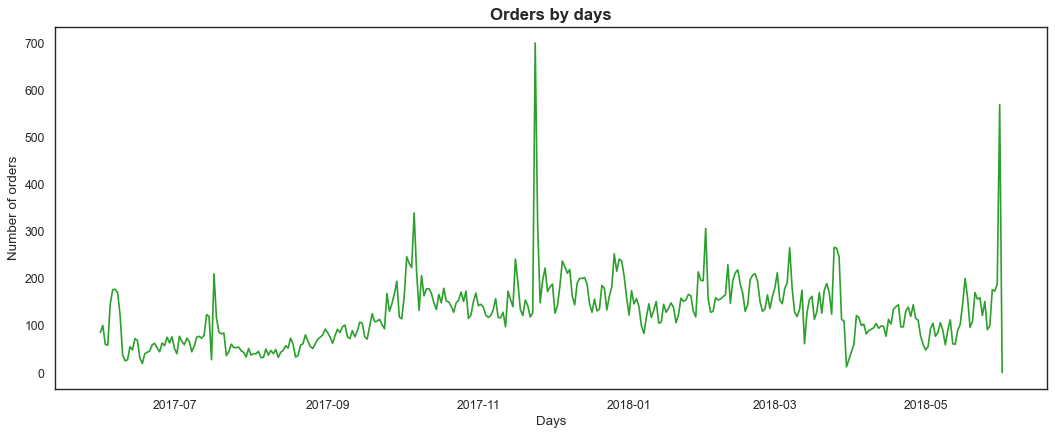

In [60]:
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('date', 'n_orders', data=daily_orders, color='tab:green')
plt.title("Orders by days", fontsize=15, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Number of orders')
plt.show()

In [61]:
buyers = orders.groupby(['Uid']).agg({'Revenue' : 'sum'}).reset_index()

In [62]:
visits_buyers = visits[['Uid', 'Source Id', 'first_activity_month']]
visits_buyers = visits_buyers.drop_duplicates('Uid')

In [63]:
buyers = buyers.merge(visits_buyers, on='Uid', how='left')

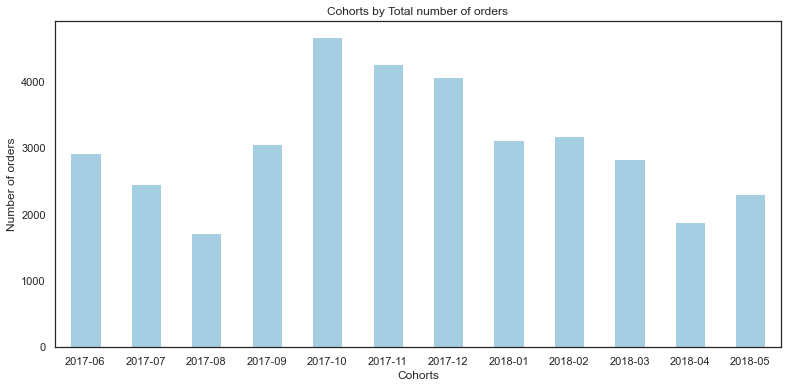

In [64]:
cohorts_by_orders = buyers.groupby('first_activity_month').agg({'Uid': 'nunique'}).reset_index()
cohorts_by_orders['first_activity_month'] = cohorts_by_orders['first_activity_month'].dt.strftime('%Y-%m')
cohorts_by_orders.columns = ['Cohorts', 'Number of Orders']
ax3 = cohorts_by_orders.plot.bar(x='Cohorts', y='Number of Orders', 
                                legend=False, 
                                rot=0, 
                                colormap='Paired', 
                                title='Cohorts by Total number of orders',
                                figsize=(13,6))
plt.xlabel('Cohorts')
plt.ylabel('Number of orders')
plt.show()

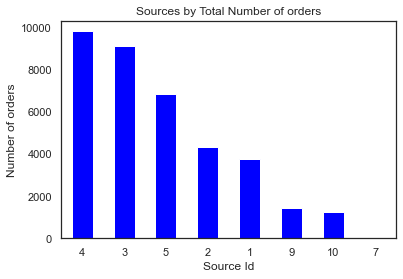

In [65]:
sources_by_orders = buyers.groupby('Source Id').agg({'Uid':'nunique'}).reset_index()
sources_by_orders.columns = ['Source Id', 'Number of Orders']
sources_by_orders['Source Id'] =  sources_by_orders['Source Id'].astype('category')
sources_by_orders.sort_values(by='Number of Orders', ascending=False, inplace=True)
ax = sources_by_orders.plot.bar(x='Source Id', y='Number of Orders', 
                                legend=False, 
                                rot=0, 
                                colormap='winter', 
                                title='Sources by Total Number of orders')
plt.xlabel('Source Id')
plt.ylabel('Number of orders')
plt.show()

**128** is the average number of orders per day. In Decemer was tremendous rise (up to 700) which just continues to confirm the up standing interest of users to the service duting winter vacations season.  
As for users - for the last 6 months (from 2017-12-01), **1,08** orders on average per one user.  
**1st and 2nd** sources are the most 'profitable' in terms of users for the service. However, we know that **3rd and 5th** are more effective in conversion (I cant say anything about 10th because the numver of orders very low, so it seems it is early to make conclusions on effectiveness of this source).

[back to contents](#contents)

##### Average purchase size <a class="anchor" id="section_2_2_3"></a>

- What is the average purchase size?

In [66]:
print('Average revenue per order:', round(orders['Revenue'].mean()))

Average revenue per order: 5


In [67]:
daily_revenue = orders.groupby(['order_date']).agg({'Revenue': 'mean'}).reset_index()
daily_revenue.columns = ['date', 'revenue']

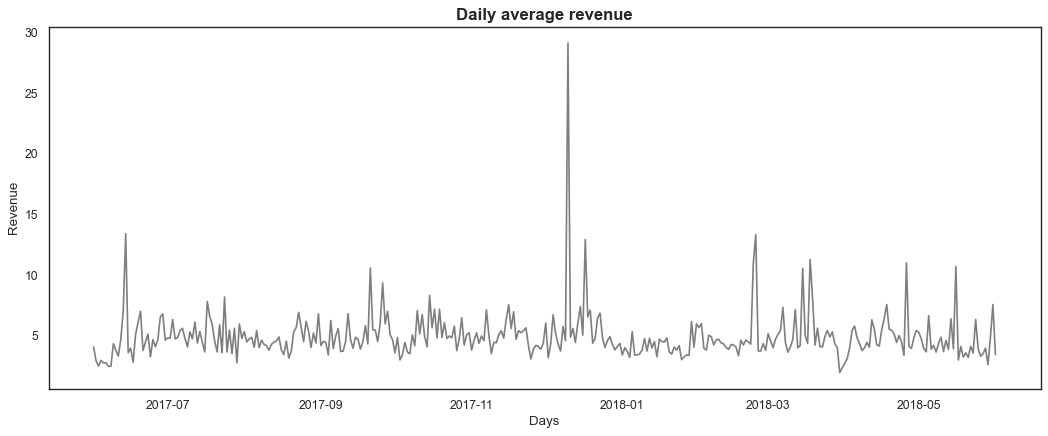

In [68]:
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('date', 'revenue', data=daily_revenue, color='tab:grey')
plt.title("Daily average revenue", fontsize=15, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Revenue')
plt.show()

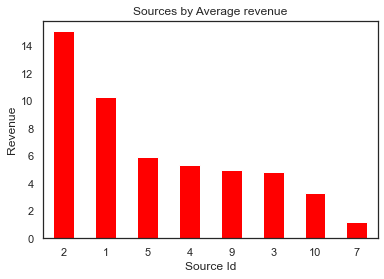

In [69]:
sources_by_revenue = buyers.groupby('Source Id').agg({'Revenue':'mean'}).reset_index()
sources_by_revenue.columns = ['Source Id', 'Revenue']
sources_by_revenue['Source Id'] =  sources_by_revenue['Source Id'].astype('category')
sources_by_revenue.sort_values(by='Revenue', ascending=False, inplace=True)
ax1 = sources_by_revenue.plot.bar(x='Source Id', y='Revenue', 
                                legend=False, 
                                rot=0, 
                                colormap='flag', 
                                title='Sources by Average revenue')
plt.xlabel('Source Id')
plt.ylabel('Revenue')
plt.show()

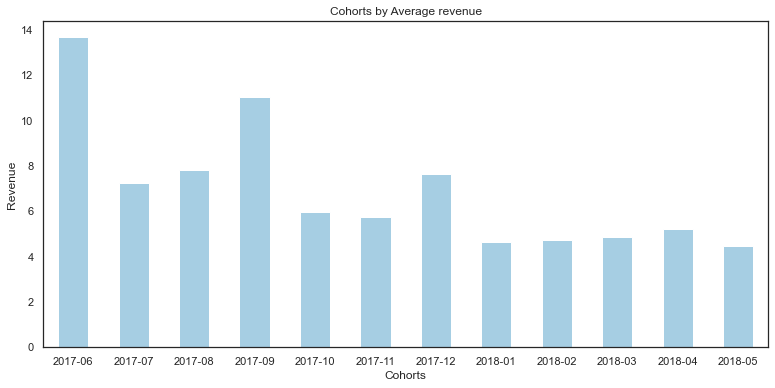

In [70]:
cohorts_by_revenue = buyers.groupby('first_activity_month').agg({'Revenue':'mean'}).reset_index()
cohorts_by_revenue['first_activity_month'] = cohorts_by_revenue['first_activity_month'].dt.strftime('%Y-%m')
#cohorts_by_revenue.columns = ['first_activity_month', 'Revenue']
ax1 = cohorts_by_revenue.plot.bar(x='first_activity_month', y='Revenue', 
                                legend=False, 
                                rot=0, 
                                colormap='Paired', 
                                title='Cohorts by Average revenue',
                                figsize=(13,6))
plt.xlabel('Cohorts')
plt.ylabel('Revenue')
plt.show()

The average daily revenue is **5** in some currency.   
The rise in average revnue was in December, in the middle of the summer and in autumn (supposively during school kids fall vacations).  
**2nd, 1st, 4th and 5th** sources are the most profitable in terms of money.   
**The oldest cohort June 2017** spent the most on average. But September and December users are also quite profitable ones.

[back to contents](#contents)

##### LTV <a class="anchor" id="section_2_2_4"></a>

- How much money do they bring? (LTV)

In [71]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]')
costs['month'] = costs['dt'].astype('datetime64[M]')

In [72]:
first_order = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_order.columns = ['Uid', 'first_order_month']

In [73]:
cohort_sizes = first_order.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [74]:
orders_ = pd.merge(orders,first_order, on='Uid')
cohorts1 = orders_.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()

In [75]:
report1 = pd.merge(cohort_sizes, cohorts1, on='first_order_month')
report1.head()

,first_order_month,n_buyers,order_month,Revenue
0,2017-06-01,2022,2017-06-01,9557.49
1,2017-06-01,2022,2017-07-01,981.82
2,2017-06-01,2022,2017-08-01,885.34
3,2017-06-01,2022,2017-09-01,1931.30
4,2017-06-01,2022,2017-10-01,2068.58


As soon as I dont know all the costs (only marketing), I will take **margin rate as 0.5** (as it was presented in the theory as some generalized figure which can be used for calculations) 

In [76]:
margin_rate = .5

report1['gp'] = report1['Revenue'] * margin_rate
report1['age'] = (report1['order_month'] - report1['first_order_month']) / np.timedelta64(1, 'M')
report1['age'] = report1['age'].round().astype('int')

In [77]:
report1['ltv'] = report1['gp'] / report1['n_buyers']
output1 = report1.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(2)

output1.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2.36,0.24,0.22,0.48,0.51,0.37,0.48,0.29,0.28,0.3,0.29,0.13
2017-07-01,3.01,0.17,0.31,0.18,0.09,0.08,0.06,0.07,0.08,0.07,0.08,
2017-08-01,2.64,0.24,0.23,0.2,0.25,0.14,0.11,0.2,0.15,0.09,,
2017-09-01,2.82,0.56,0.26,1.99,0.2,0.32,0.35,0.12,0.09,,,
2017-10-01,2.50,0.27,0.1,0.08,0.08,0.06,0.04,0.06,,,,
2017-11-01,2.58,0.2,0.1,0.16,0.07,0.03,0.06,,,,,
2017-12-01,2.37,0.13,0.46,0.53,0.16,0.17,,,,,,
2018-01-01,2.07,0.15,0.15,0.07,0.03,,,,,,,
2018-02-01,2.08,0.14,0.04,0.04,,,,,,,,


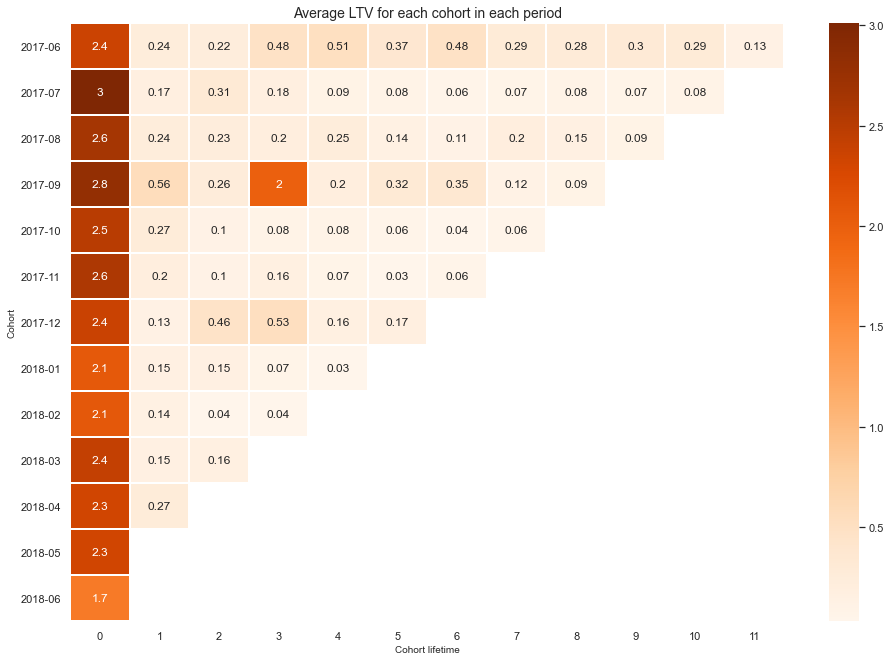

In [78]:
plt.figure(figsize=(16, 11))
sns.heatmap(output1,
            annot=True,
            linewidths=1,
            linecolor='white',
            cmap='Oranges').set_yticklabels(output1.index.strftime('%Y-%m'))
plt.xlabel('Cohort lifetime', fontsize = 10)
plt.ylabel('Cohort', fontsize = 10)
plt.title('Average LTV for each cohort in each period', fontsize = 14)
plt.show()

In [79]:
(report1[report1['first_order_month'] >= '2017-12-01']['Revenue'].sum() / 
 cohort_sizes[cohort_sizes['first_order_month'] >= '2017-12-01']['n_buyers'].sum()).round(2)

5.54

So again ther was some kind of anomality in **September cohort** which brought maximum average revenue. They can explain that drastic rise in December. Probably there was some cool promotion in September which gave bonuses  later (in 3 months).  
Regardless of September cohort it shows that **June cohort** (the 'oldest' users) is the most profitable in terms of bringing money.  
**5,54** is LTV value pr customer for 6 months (since 2017-12-01) after the first purchase.

[back to contents](#contents)

#### MARKETING <a class="anchor" id="section_3_2"></a>

##### Costs  <a class="anchor" id="section_3_2_1"></a>

- How much money was spent? Overall/per source/over time


In [80]:
sources_costs = costs.groupby(['source_id']).agg({'costs' : ('sum', 'mean')})
sources_costs.columns = ['total_costs', 'average_costs']
sources_costs.sort_values(by='total_costs', ascending = False, inplace=True)
sources_costs

,total_costs,average_costs
source_id,,
3,141321.63,389.315785
4,61073.60,168.246832
5,51757.10,142.189835
2,42806.04,117.922975
1,20833.27,57.391928
10,5822.49,16.039917
9,5517.49,15.199697


In [81]:
print('Total cocsts for all marketing sources:', sources_costs['total_costs'].sum().round(2))

Total cocsts for all marketing sources: 329131.62


In [82]:
daily_costs = costs.groupby(['dt']).agg({'costs' : ('sum', 'mean')}).reset_index()
daily_costs.columns = ['Date', 'Total', 'Average']

In [83]:
print('Average faily costs:',round(daily_costs['Average'].mean(), 2))

Average faily costs: 129.17


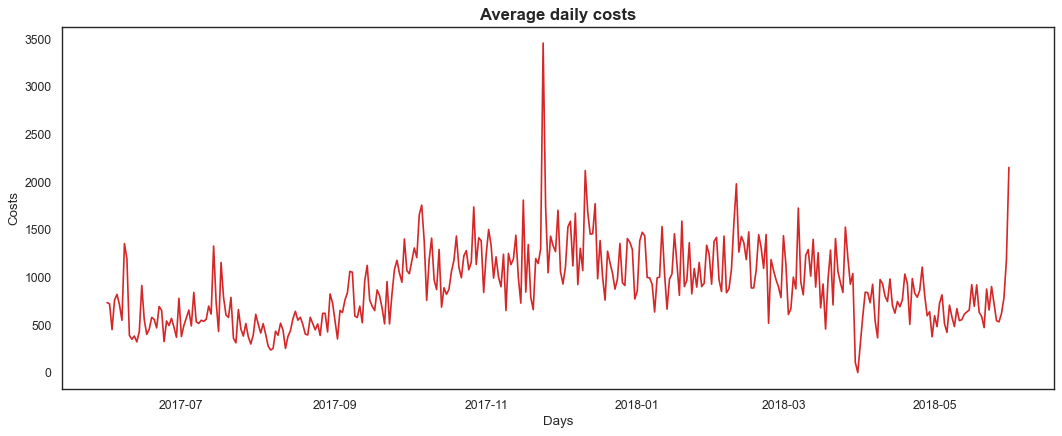

In [84]:
plt.figure(figsize=(16,6), dpi= 80)
plt.plot('Date', 'Total', data=daily_costs, color='tab:red')
plt.title("Average daily costs", fontsize=15, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Costs')
plt.show()

In [85]:
costs['month'] = costs['dt'].values.astype('datetime64[M]')
sources_by_months = costs.pivot_table(index=['month'],
                                      columns='source_id', 
                                      values='costs', 
                                      aggfunc='sum').reset_index()
sources_by_months.columns = ['month', '1', '2', '3', '4', '5', '9', '10']

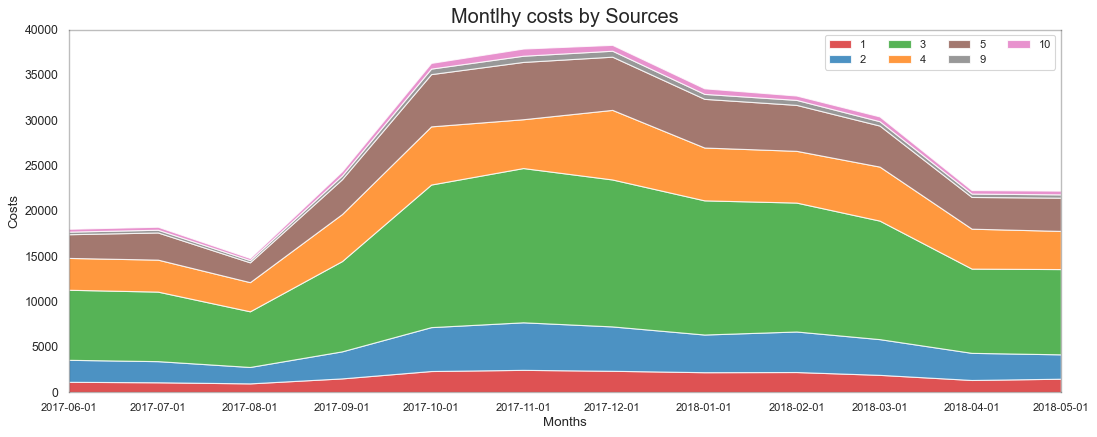

In [86]:
# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 6), dpi= 80)
columns = sources_by_months.columns[1:]
labs = columns.values.tolist()

# Prepare data
x = sources_by_months['month'].astype('O').values.tolist()
y1 = sources_by_months['1'].values.tolist()
y2 = sources_by_months['2'].values.tolist()
y3 = sources_by_months['3'].values.tolist()
y4 = sources_by_months['4'].values.tolist()
y5 = sources_by_months['5'].values.tolist()
y6 = sources_by_months['9'].values.tolist()
y7 = sources_by_months['10'].values.tolist()
y = np.vstack([y1, y2, y3, y4, y5, y6, y7])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Montlhy costs by Sources', fontsize=18)
ax.set(ylim=[0, 40000])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[:], fontsize=10, horizontalalignment='center')
plt.xlim(x[0], x[-1])
# Lighten borders
plt.gca().spines["top"].set_alpha(0.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0.3)
plt.gca().spines["left"].set_alpha(.3)
plt.xlabel('Months')
plt.ylabel('Costs')
plt.show()

In total **329131.62** were spent for marketing campaigns in different sources. **129.17** were spent on average daily. Also we see overall monthly rising of expenses.    
Afisha spends the most bugdet on the **3rd** source but in terms of orders and average money recieved from users.

[back to contents](#contents)

##### CAC <a class="anchor" id="section_3_2_2"></a>
- How much did customer acquisition from each of the sources cost?

In [87]:
source_buyers = buyers.groupby('Source Id').agg({'Uid' : 'nunique'}).reset_index()
source_buyers.columns =['source_id', 'n_users']

In [88]:
sources_costs = sources_costs.merge(source_buyers, on='source_id')

In [89]:
sources_costs['cac_source'] = sources_costs['total_costs']/sources_costs['n_users']
sources_costs['cac_source'] = sources_costs['cac_source'].round(2)
sources_costs

,source_id,total_costs,average_costs,n_users,cac_source
0,3,141321.63,389.315785,9134,15.47
1,4,61073.60,168.246832,9822,6.22
2,5,51757.10,142.189835,6838,7.57
3,2,42806.04,117.922975,4320,9.91
4,1,20833.27,57.391928,3740,5.57
5,10,5822.49,16.039917,1239,4.70
6,9,5517.49,15.199697,1415,3.90


In [90]:
print('Average CAC per source:', round(sources_costs['cac_source'].mean(), 2))

Average CAC per source: 7.62


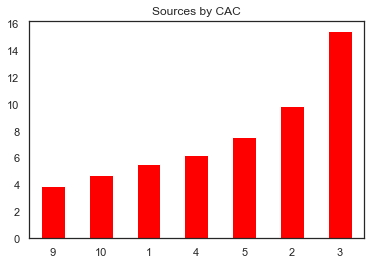

In [91]:
sources_costs.sort_values(by='cac_source', ascending=True, inplace=True)
ax3 = sources_costs.plot.bar(x='source_id', y='cac_source', 
                                legend=False, 
                                rot=0, 
                                colormap='flag', 
                                title='Sources by CAC')
plt.xlabel('')
plt.show()

In [92]:
montlhy_costs = costs.groupby('month')['costs'].sum().reset_index()

In [93]:
report_romi = pd.merge(report1, montlhy_costs, left_on='first_order_month', right_on='month')
report_romi['cac'] = report_romi['costs'] / report_romi['n_buyers']

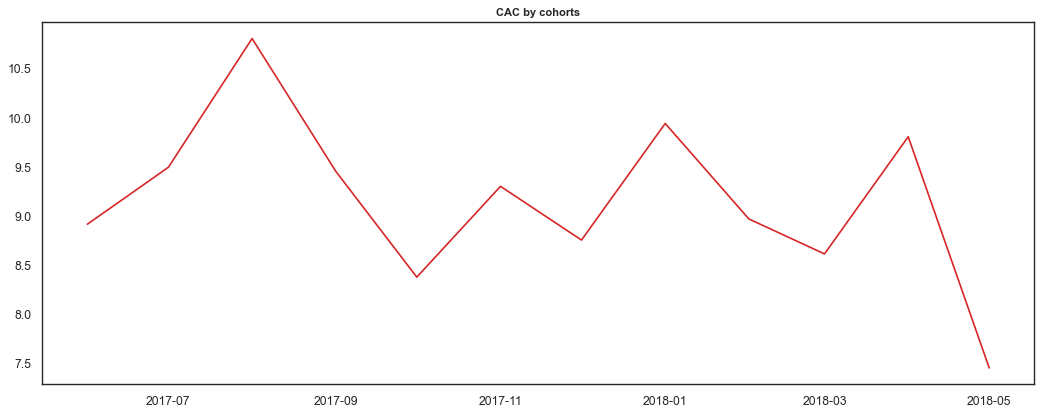

In [94]:
cac_by_cohorts = report_romi.groupby(['first_order_month']).agg({'cac':'mean'}).reset_index()

plt.figure(figsize=(16,6), dpi= 80)
plt.plot('first_order_month', 'cac', data=cac_by_cohorts, color='tab:red')
plt.title("CAC by cohorts", fontsize=10, fontweight='bold')
plt.show()

**3rd source** proves its ineffeciency again - it is the most expensive source in terms of attracting a user but doesnt provide enough orders and money.  
The August cohort seemed to be the most expensive to attract.

[back to contents](#contents)

##### ROI <a class="anchor" id="section_3_2_3"></a>
- How worthwhile where the investments?


In [95]:
report_romi.head()

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv,month,costs,cac
0,2017-06-01,2022,2017-06-01,9557.49,4778.745,0,2.363375,2017-06-01,18015.0,8.909496
1,2017-06-01,2022,2017-07-01,981.82,490.910,1,0.242784,2017-06-01,18015.0,8.909496
2,2017-06-01,2022,2017-08-01,885.34,442.670,2,0.218927,2017-06-01,18015.0,8.909496
3,2017-06-01,2022,2017-09-01,1931.30,965.650,3,0.477572,2017-06-01,18015.0,8.909496
4,2017-06-01,2022,2017-10-01,2068.58,1034.290,4,0.511518,2017-06-01,18015.0,8.909496


In [96]:
report_romi['romi'] = report_romi['ltv'] / report_romi['cac']
output_romi = report_romi.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

output_romi.cumsum(axis=1).round(2)
output_romi.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.265265,0.0272501,0.0245723,0.0536026,0.0574127,0.0412967,0.053325,0.032655,0.0310616,0.0340136,0.0320749,0.0144219
2017-07-01,0.316811,0.0176697,0.0328676,0.0189224,0.00931905,0.00822561,0.00633642,0.00747564,0.0084989,0.00775633,0.00820587,
2017-08-01,0.244373,0.0218596,0.0212338,0.0181214,0.0228812,0.0131317,0.00975657,0.0187573,0.0135333,0.0087059,,
2017-09-01,0.298916,0.0591838,0.0275129,0.210545,0.0212123,0.0342666,0.0371549,0.0128764,0.00974438,,,
2017-10-01,0.298933,0.0320075,0.0114343,0.00938816,0.00905449,0.00719065,0.00506705,0.00689841,,,,
2017-11-01,0.277513,0.0214512,0.0107417,0.0174915,0.00795547,0.00290019,0.00618631,,,,,
2017-12-01,0.271064,0.0148925,0.0529122,0.0609299,0.0178984,0.0193351,,,,,,
2018-01-01,0.208086,0.0148309,0.01531,0.00718394,0.00315467,,,,,,,
2018-02-01,0.231903,0.0155239,0.0043801,0.00413623,,,,,,,,


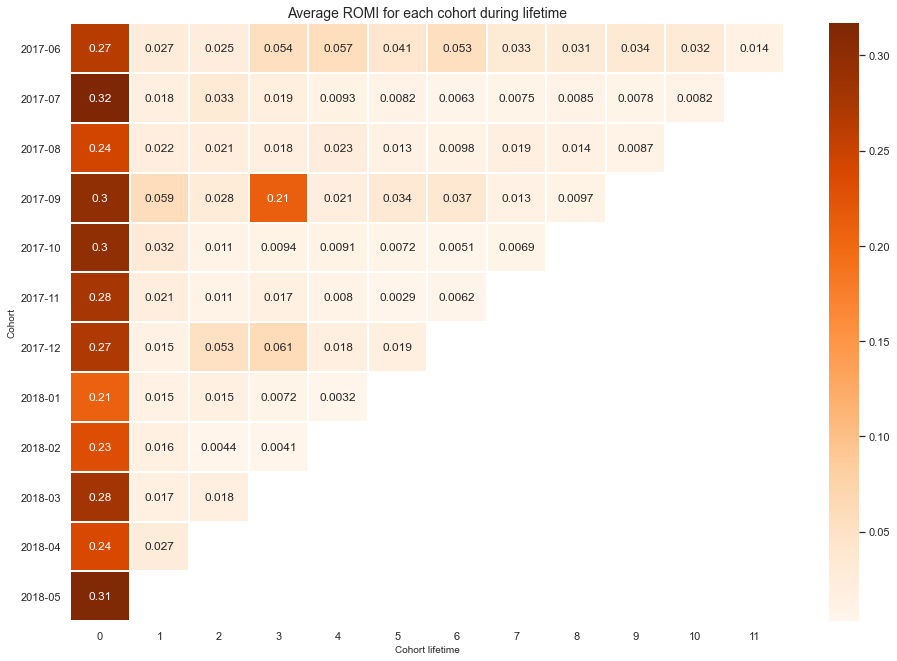

In [97]:
plt.figure(figsize=(16, 11))
sns.heatmap(output_romi,
            annot=True,
            linewidths=1,
            linecolor='white',
            cmap='Oranges').set_yticklabels(output1.index.strftime('%Y-%m'))
plt.xlabel('Cohort lifetime', fontsize = 10)
plt.ylabel('Cohort', fontsize = 10)
plt.title('Average ROMI for each cohort during lifetime', fontsize = 14)
plt.show()

In [98]:
sources_by_total_revenue = buyers.groupby('Source Id').agg({'Revenue':'sum'}).reset_index()
sources_by_total_revenue.columns = ['source_id', 'total_revenue']
sources_by_total_revenue

,source_id,total_revenue
0,1,38560.06
1,2,65152.26
2,3,44317.68
3,4,52479.75
4,5,40357.91
5,7,1.22
6,9,7076.98
7,10,4111.34


In [99]:
sources_costs = sources_costs.merge(sources_by_total_revenue, on='source_id')

In [100]:
sources_costs['gp'] = sources_costs['total_revenue'] * margin_rate
sources_costs['ltv'] = sources_costs['gp']/sources_costs['n_users']
sources_costs['romi'] = sources_costs['ltv']/sources_costs['cac_source']

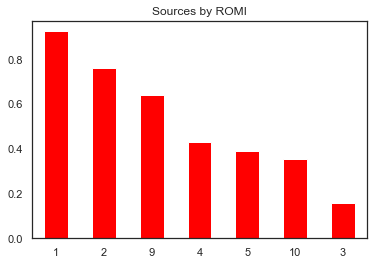

In [101]:
sources_costs.sort_values(by='romi', ascending=False, inplace=True)
ax4 = sources_costs.plot.bar(x='source_id', y='romi', 
                                legend=False, 
                                rot=0, 
                                colormap='flag', 
                                title='Sources by ROMI')
plt.xlabel('')
plt.show()

In [102]:
total_revenue = orders['Revenue'].sum()
total_expenses = costs['costs'].sum()
roi = total_revenue*margin_rate / total_expenses
print('ROI with 0.5 margin rate:', '{:.1f}%'.format(100 * (total_revenue*margin_rate / total_expenses)),
      '\n''ROI with 0 margin rate:', '{:.1f}%'.format(100 * (total_revenue / total_expenses)))

ROI with 0.5 margin rate: 38.3% 
ROI with 0 margin rate: 76.6%


The first **June** cohort is the most profitable during the its lifetime. **December** cohort is 'famous' because of its profitability later, in 3 months after joining.  
As for sources, the highest ROMI goes to the **1st, 2nd** sources 

[back to contents](#contents)

### 3. Conclusions <a class="anchor" id="chapter3"></a>

Afisha is quite popular service - almost **1000 daily active users**.  
It is usually **one** session per user per day. 
The sessions are usually short - **1 minute** as the most frequent ASL or **5 minutes** (median value).  Important to mention that smartphone users spent more time than desktop.  
Retention rate shows how often users come back. As analysis showed, the most loyal customers were **June-Jule 2017 cohorts**.  
Conversion is important to understand how the users convert from visitors to buyers. I found out that the biggest share of users **(~70%)** return **on the same day**, but there is still a big share of users who dont convert even after 30 days and more. I think this group of users should more precise investigation.  
For 1000 daily active users we get around **130** orders per day. **1.08** order per user for the last six months. The rate is not really high but it could be related to the specifity of Afisha service - going out to cinemas, concerts, theatres and etc. - is a leisure activity which is not necessarily repeated every month or even every half year.  
**5** dollars is the average sum of money spent on the source.  
LTV shows how much money users can bring in all. **The highest LTV in the first months** of service usage (it corresponds to the conclusion of users returning on the same day for the purchase). Afterwards LTV gradually goes down.  **
**329131** dollars is the total money spent on advertising. **130** dollars are spent daily.  
CAC shows how much does to cost to attract a buyer. The calculations showed that on average for source it is 7.6 dollars (which exceeds 5-dollar-average purchases) but this values is highly influenced by source type, so we cant say that our campaigns are not effective at all. They are working, but need some improvements.  **The dynamics of CAC also show the high level of seasonality - Afisha spends more in the periods of low demand**.  
**Around 40% investments return in first month**. The rate is low, but the number of users is high, and working on conversion will increase it. 

The dynamics of Afisha using seems to be seasonal - with the rise in winter and downs during 'mid-season'.  
According to the data received there was significant effort in Decemner (in terms of costs which than led to the rise in users, orders and all).  So I would to recommend to take that campaign into the account as soons as it hit the market in a right way. 

As for sources **3rd** definetely needs revision - the amount of money invested doesnot give enough return. 
I would recomment **1st and 4th** as perspective and effecient in terms of users and profits.

[back to contents](#contents)